# Recomendation system aproches

In [297]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [298]:
import sys
sys.path.append('./src')

import collections
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import DenseFeatures, Input, Reshape, \
    Dot, Embedding, Add, Activation, Lambda, \
    Concatenate, Dense, Dropout, concatenate

from callback import MetricsPlotter
from data import InMemoryXyDataGenerator, DataSetDataGenerator, MovieLensDataSource
from util import tf_detected_devices, tf_version, plot_default_hyper_model, \
    plot_model, dataframe_to_dataset

from model import ModelInputBuilder

### Check environment

Show GPU model:

In [299]:
!nvidia-smi --query-gpu=gpu_name,memory.total --format=csv | sed -n 2p

GeForce GTX 1060, 6078 MiB


Let's check tensorflow version:

In [300]:
tf_version()

'Tensorflow version: 2.3.0'

Let's check devices that tensorflow detect:

In [301]:
tf_detected_devices()

,Name,Device Type,Memory,Description
0,/device:CPU:0,CPU,256M,
1,/device:XLA_CPU:0,XLA_CPU,16G,device: XLA_CPU device
2,/device:XLA_GPU:0,XLA_GPU,16G,device: XLA_GPU device
3,/device:GPU:0,GPU,4G,"device: 0, name: GeForce GTX 1060, pci bus id:..."


[What is XLA?](https://medium.com/@xianbao.qian/use-xla-with-keras-3ca5d0309c26)

### Download dataset

Create a data source to download and read dataset files:

In [302]:
ds = MovieLensDataSource()

Available files:

In [303]:
print(ds.files())

['ratings.csv', 'links.csv', 'movies.csv', 'tags.csv']


Rating that users give to each movie:

In [304]:
ratings = ds.get_df('ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Movie catalog: Each movie has a tittle and a list of genres.

In [305]:
movies = ds.get_df('movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Tags that users put to movies: Each line of this file after the header row represents one tag applied to one movie by one user.

In [306]:
movies = ds.get_df('tags.csv')
movies.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


**Links** file contains one row by movie and eack column represent the movie id for each movie site:

* **movieId**: is an identifier for movies used by <https://movielens.org>. E.g., the movie Toy Story has the link <https://movielens.org/movies/1>.

* **imdbId**: is an identifier for movies used by <http://www.imdb.com>. E.g., the movie Toy Story has the link <http://www.imdb.com/title/tt0114709/>.

* **tmdbId**: is an identifier for movies used by <https://www.themoviedb.org>. E.g., the movie Toy Story has the link <https://www.themoviedb.org/movie/862>

**Note**: It will we usefull when we test each model.

In [307]:
movies = ds.get_df('links.csv')
movies.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


## Analize and prepare the required data

First, get 15 users with highest total ratings sum: 

In [308]:
g = ratings.groupby('userId')['rating'].count()
top_users = g.sort_values(ascending=False)[:15]

top_users.to_frame().head()

,rating
userId,
414,2698
599,2478
474,2108
448,1864
274,1346


Get 15 movies with highest total ratings sum:

In [309]:
g = ratings.groupby('movieId')['rating'].count()
top_movies = g.sort_values(ascending=False)[:15]

top_movies.to_frame().head()

,rating
movieId,
356,329
318,317
296,307
593,279
2571,278


Build next table only with top users and movies ([Because use inner join](https://www.datacamp.com/community/tutorials/joining-dataframes-pandas?utm_source=adwords_ppc&utm_campaignid=1455363063&utm_adgroupid=65083631748&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=&utm_creative=332602034364&utm_targetid=aud-438999696719:dsa-429603003980&utm_loc_interest_ms=&utm_loc_physical_ms=9041032&gclid=Cj0KCQjwhIP6BRCMARIsALu9LfkDhKFrq-wuEKjjsNxhSBa-315ZxQKIfKV633ynuWrZnqX-jCh7ZMcaArPmEALw_wcB)):

In [310]:
top_r = ratings.join(top_users, rsuffix='_top_user', how='inner', on='userId')
top_r = top_r.join(top_movies, rsuffix='_top_movie', how='inner', on='movieId')
top_r = top_r[['userId','movieId', 'rating']]
top_r.head()

,userId,movieId,rating
10360,68,1,2.5
26092,182,1,4.0
36374,249,1,4.0
39229,274,1,4.0
42114,288,1,4.5


Show users vs. movies ratings: It can appresciated that some user did not give a rating to some movies (NaN).

In [311]:
pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,1,50,110,260,296,318,356,480,527,589,593,1196,2571,2858,2959
userId,,,,,,,,,,,,,,,
68,2.5,3.0,2.5,5.0,2.0,3.0,3.5,3.5,4.0,3.5,3.5,5.0,4.5,5.0,2.5
182,4.0,4.5,3.5,3.5,5.0,4.5,5.0,3.5,4.0,2.0,4.5,3.0,5.0,5.0,5.0
249,4.0,4.0,5.0,5.0,4.0,4.5,4.5,4.0,4.5,4.0,4.0,5.0,5.0,4.5,5.0
274,4.0,4.0,4.5,3.0,5.0,4.5,4.5,3.5,4.0,4.5,4.0,4.5,4.0,5.0,5.0
288,4.5,NaN,5.0,5.0,5.0,5.0,5.0,2.0,5.0,4.0,5.0,4.5,3.0,NaN,3.5
307,4.0,4.5,3.5,3.5,4.5,4.5,4.0,3.5,4.5,2.5,4.5,3.0,3.5,4.0,4.0
380,5.0,4.0,4.0,5.0,5.0,3.0,5.0,5.0,NaN,5.0,5.0,5.0,4.5,NaN,4.0
387,NaN,4.5,3.5,4.5,5.0,3.5,4.0,3.0,NaN,3.5,4.0,4.5,4.0,4.5,4.5
414,4.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,5.0,5.0


Transform categorical columns values to values from 0 to N-1:

In [312]:
user_enc = LabelEncoder()
ratings['user'] = user_enc.fit_transform(ratings['userId'].values)
n_users = ratings['user'].nunique()

item_enc = LabelEncoder()
ratings['movie'] = item_enc.fit_transform(ratings['movieId'].values)
n_movies = ratings['movie'].nunique()

ratings['rating'] = ratings['rating'].values.astype(np.float32)
min_rating = min(ratings['rating'])
max_rating = max(ratings['rating'])

Users and movies count:

In [313]:
n_users, n_movies

(610, 9724)

Min and max rating:

In [314]:
min_rating, max_rating

(0.5, 5.0)

Build X and y sets (Equivalent to features and label for ech training test).

In [315]:
X = ratings[['user', 'movie']].values
y = ratings['rating'].values

Show feateures an label for first sample:

In [316]:
X[0], y[0]

(array([0, 0]), 4.0)

Split data to train, validation and test sets:

In [317]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((70585, 2), (30251, 2), (70585,), (30251,))

## Wide & Deep

In [318]:
dataset = pd.DataFrame()
dataset['user'] = ratings['user']
dataset['movie'] = ratings['movie']

dataset['user1'] = ratings['user'].astype('string')
dataset['movie1'] = ratings['movie'].astype('string')

dataset['user2'] = dataset['user'].astype('string')
dataset['movie2'] = dataset['movie'].astype('string')
dataset['rating'] = ratings['rating']

dataset.head()

,user,movie,user1,movie1,user2,movie2,rating
0,0,0,0,0,0,0,4.0
1,0,2,0,2,0,2,4.0
2,0,5,0,5,0,5,4.0
3,0,43,0,43,0,43,5.0
4,0,46,0,46,0,46,5.0


In [319]:
dataset.dtypes

user        int64
movie       int64
user1      string
movie1     string
user2      string
movie2     string
rating    float32
dtype: object

In [320]:
users_num  = dataset['user'].unique()
movies_num = dataset['movie'].unique()

users_str  = dataset['user2'].unique()
movies_str = dataset['movie2'].unique()

In [321]:
len(users_num), len(movies_num)

(610, 9724)

In [322]:
last_user_id = int(users_num[-1])+1
last_movie_id = int(movies_num[-1])+1

In [323]:
print(f'User ids: from 0 to {last_user_id} - Movie ids: from 0 to {last_movie_id}.')

User ids: from 0 to 610 - Movie ids: from 0 to 9373.


In [324]:
wide_inputs = ModelInputBuilder()

user_id_cat = wide_inputs.cat_id("user", ids_count=len(users_num)+1, unknown_value=last_user_id)
movie_id_cat = wide_inputs.cat_id("movie", ids_count=len(movies_num)+1, unknown_value=last_movie_id)
None

In [325]:
user1_cat  = wide_inputs.cat_one_hot("user1", users_str)
movie1_cat = wide_inputs.cat_one_hot("movie1", movies_str)

wide_inputs.cat_one_hot_crossed(columns=[user1_cat,  movie1_cat], hash_bucket_size=int(1000))
None

In [326]:
deep_inputs = ModelInputBuilder()
deep_inputs.cat_embedding("user2", users_str, dimension=50)
deep_inputs.cat_embedding("movie2", movies_str, dimension=50)
None

In [327]:
Layer = collections.namedtuple('Layer', 'units act dropout')

class WideAndDeepModelFactory:
    @staticmethod
    def create(
        wide_input_setttings, 
        deep_input_setttings,
        deep_hidden_layers,
        lr,
        loss='mean_squared_error'
    ):
        wide = DenseFeatures(
            wide_input_setttings.feature_columns(), 
            name='Wide_Features'
        )(wide_input_setttings.inputs_dic())
        # wide = Dropout(0.2)(wide)

        deep = DenseFeatures(
            deep_input_setttings.feature_columns(), 
            name='Deep_Features'
        )(deep_input_setttings.inputs_dic())

        for idx, layer in enumerate(deep_hidden_layers):
            layer_name = f'Deep_Hidden_{idx+1}'
            deep = Dense(name=layer_name, units=layer.units, activation=layer.act)(deep)
            deep = Dropout(layer.dropout)(deep)

        both = concatenate([deep, wide], name='Deep_Wide')
        
        output = Dense(1, kernel_initializer='he_normal')(both)
        output = Activation('sigmoid')(output)
        output = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(output)
        
        inputs = list(wide_input_setttings.inputs()) + list(deep_input_setttings.inputs())

        model = Model(inputs, output)

        model.compile(optimizer=Adam(lr), loss=loss)

        return model

In [328]:
model = WideAndDeepModelFactory.create(
    wide_inputs, 
    deep_inputs, 
    deep_hidden_layers=[
        Layer(units=700, act='relu', dropout=0.2)
    ],
    lr=0.001
)

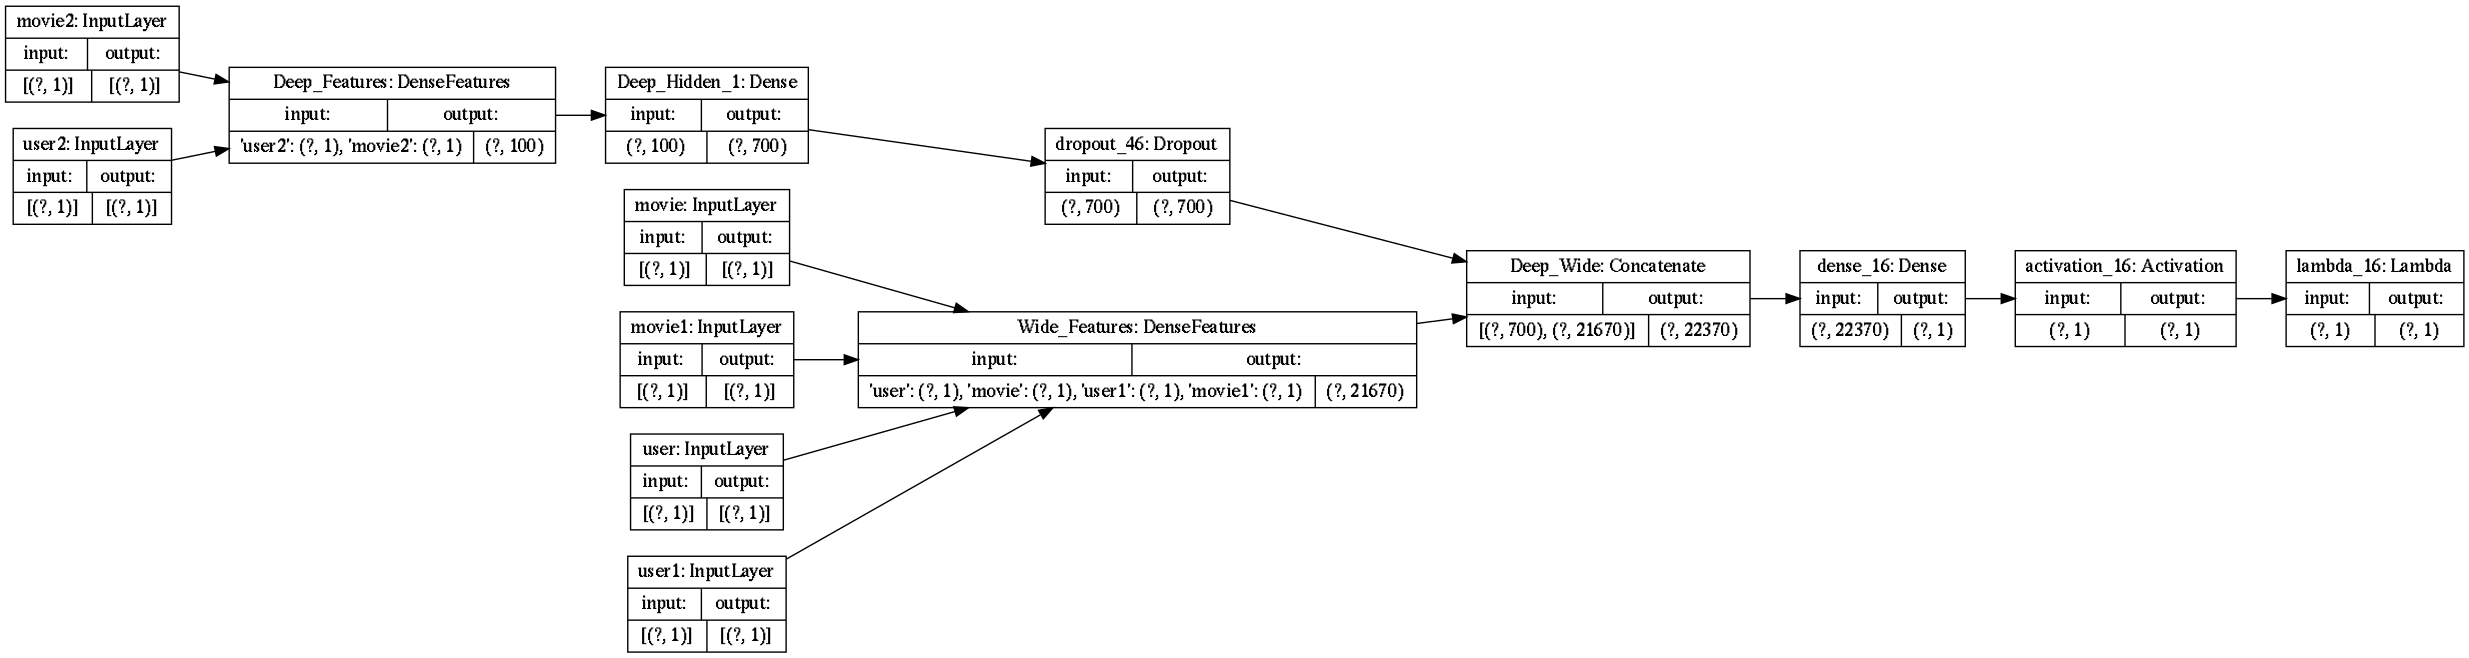

In [329]:
plot_model(model)

In [330]:
df_train, df_test = train_test_split(dataset, test_size=0.2)
df_train, df_val = train_test_split(df_train, test_size=0.2)

print(len(df_train), 'train examples')
print(len(df_val), 'validation examples')
print(len(df_test), 'test examples')

64534 train examples
16134 validation examples
20168 test examples


In [331]:
batch_size=32
val_batch_size=batch_size

train_ds = dataframe_to_dataset(df_train,  label='rating',  shuffle=True, batch_size=batch_size)
test_ds = dataframe_to_dataset(df_test, label='rating', batch_size=batch_size)
val_ds = dataframe_to_dataset(df_val, label='rating', batch_size=batch_size)

In [332]:
def show_data(label, dataset, batch_size, dataframe):
    batches = dataset.cardinality().numpy()
    print(f'{label} - Batches(size: {batch_size}): {batches}, Samples: {len(dataframe)}')

In [333]:
show_data('Train', train_ds, batch_size, df_train)

Train - Batches(size: 32): 2017, Samples: 64534


In [334]:
show_data('Test', test_ds, batch_size, df_test)

Test - Batches(size: 32): 631, Samples: 20168


In [335]:
show_data('Validation', val_ds, val_batch_size, df_val)

Validation - Batches(size: 32): 505, Samples: 16134


In [336]:
callbacks=[
     MetricsPlotter(
         validation_generator=DataSetDataGenerator(val_ds), 
         metrics_names=['loss'],
         plot_interval=400,
         evaluate_interval=500,
         batch_size=batch_size
     )
]

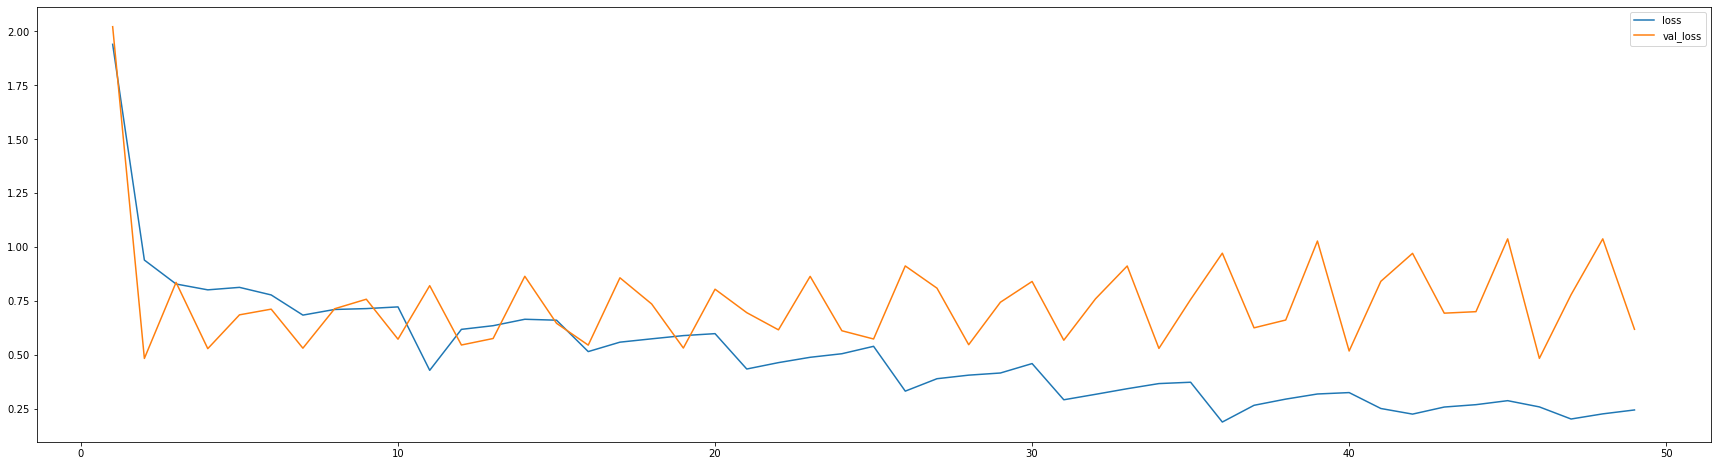



Evaluate model (Each 500 steps):
1/1 [==============================] - ETA: 0s - loss: 0.734 - 0s 3ms/step - loss: 0.7342

Validation:
  - Loss (50): 0.734248 (⟰ 0.11476183)

Continue model train:
2017/2017 - 9s - loss: 0.2913


In [337]:
model.fit(
    train_ds, 
    batch_size=batch_size,
    use_multiprocessing=True,
    workers=8,
    epochs=10,
    verbose=2,
    callbacks=callbacks
)

In [338]:
model.evaluate(test_ds)

631/631 [==============================] - ETA: 0s - loss: 0.922 - ETA: 2s - loss: 0.898 - ETA: 2s - loss: 0.966 - ETA: 2s - loss: 0.965 - ETA: 2s - loss: 1.011 - ETA: 3s - loss: 0.997 - ETA: 2s - loss: 0.984 - ETA: 3s - loss: 1.000 - ETA: 2s - loss: 0.993 - ETA: 3s - loss: 0.988 - ETA: 2s - loss: 0.994 - ETA: 2s - loss: 0.979 - ETA: 2s - loss: 0.989 - ETA: 2s - loss: 0.975 - ETA: 2s - loss: 0.966 - ETA: 2s - loss: 0.964 - ETA: 2s - loss: 0.972 - ETA: 2s - loss: 0.979 - ETA: 2s - loss: 0.977 - ETA: 2s - loss: 0.969 - ETA: 2s - loss: 0.973 - ETA: 1s - loss: 0.978 - ETA: 1s - loss: 0.976 - ETA: 1s - loss: 0.978 - ETA: 1s - loss: 0.975 - ETA: 1s - loss: 0.974 - ETA: 1s - loss: 0.973 - ETA: 1s - loss: 0.974 - ETA: 1s - loss: 0.980 - ETA: 1s - loss: 0.985 - ETA: 1s - loss: 0.982 - ETA: 1s - loss: 0.981 - ETA: 1s - loss: 0.979 - ETA: 1s - loss: 0.980 - ETA: 1s - loss: 0.977 - ETA: 0s - loss: 0.977 - ETA: 0s - loss: 0.980 - ETA: 0s - loss: 0.979 - ETA: 0s - loss: 0.982 - ETA: 0s - loss: 0.980

0.9713661074638367